In [1]:
 

import meshio
import gmsh
import sys
from dolfin import *
import numpy as np
import pyvista as pv

# Generating MESH

In [ ]:

class FiberCompositeMeshGenerator:
    def __init__(self, L=1.0, R_input=0.035, lc=0.03, n_fibers_x=10, n_fibers_y=10, wall_gap=0.005):
        self.L = L
        self.R_input = R_input
        self.lc = lc
        self.n_fibers_x = n_fibers_x
        self.n_fibers_y = n_fibers_y

def generate(self):

    gmsh.initialize()
    gmsh.model.add("Fiber_Composite")

    

    L = 1.0     # 1 meter Domain size
    R = 0.035    # Fiber radius  
    lc = 0.03   # Mesh resolution (Balance between accuracy and condition number)
    occ = gmsh.model.occ
    
    # --- 2. Safety Calculation ---
    start_point = self.R_input + self.wall_gap
    usable_span = self.L - 2 * (self.R_input + self.wall_gap)
    step_size = usable_span / (self.n_fibers_x - 1)
    #2R<spacing to avoid overlap of fibers
    R = self.R_input
    if step_size < 2 * R:
        R = step_size * 0.45
        print(f"Safety Override: Radius shrunk to {R:.4f}")

    # Calculate max allowable radius to prevent touching each other or the wall
    # R must be less than spacing/2

    # Create Geometry
    square = occ.addRectangle(0, 0, 0, L, L) #Rectangle(x, y, z, width, height)
    # Create multiple fibers in a grid pattern
    fiber_list = []
    n_fibers_x = int(10)  # Number of fibers in x direction
    n_fibers_y = int(10)  # Number of fibers in y direction
    spacing = L / n_fibers_x

    for i in range(n_fibers_x): # Loop over number of fibers in x direction 
        for j in range(n_fibers_y): #for each x fiber, loop over number of fibers in y direction
            x_c = (i+0.5) * spacing #center of fiber in x direction. Note we add 0.5 to center to make sure its in middle of spacing. we don't want circle at edge of spacing
            y_c = (j+0.5) * spacing
            # Create disk and Both circle and square start from same plane z=0. it uses the center of the circle as the anchor point, but that center is calculated relative to the origin (0,0) of the square (Bottom-Left Corner) .
            c = occ.addDisk(x_c, y_c, 0, R, R) #Disk(x_center, y_center, z_center, radius_x, radius_y)  
            fiber_list.append((2, c))

    #  Fragment and Synchronize
    #  ov contains all resulting surfaces after the boolean operation
    ov, ovv = occ.fragment([(2, square)], fiber_list) #Fragment the square with the circle {dim, tag}. Note ovv are separate entities
    occ.synchronize()

    # Dynamically Identify Surfaces
    # The problem is that after the fragmenting.Gmsh doesn't inherently know which ID belongs to the "Matrix" and which belongs to the "Fiber." It just sees two surfaces.
    # We look for the surface whose center of mass is the center of the square. # 

    fiber_surface = []
    matrix_surface = []

    for surface in gmsh.model.getEntities(2):
        # Get mass properties (this returns [mass/area, x, y, z])
        # For a 2D surface, 'mass' is actually the area.
        mass_center = occ.getCenterOfMass(surface[0], surface[1])
                                
        # We use a tool to get the actual area
        # (Dimension 2, ID surface[1])
        mass_props = occ.getMass(surface[0], surface[1])
        area = mass_props # Area is the first element returned 

        # Logic: If it's small, it's the fiber. If it's large, it's the matrix.
        expected_fiber_area = 3.14159 * (R**2)
                                    
        if abs(area - expected_fiber_area) < 1e-4:
            fiber_surface.append(surface[1])
            print(f"Surface {surface[1]} identified as FIBER (Area: {area:.4f})")
        else:
            matrix_surface.append(surface[1])
            print(f"Surface {surface[1]} identified as MATRIX (Area: {area:.4f})")

    # Now we have the IDs for both surfaces.
    #Assign Physical Groups for Material Domains to help solver recognize them
    gmsh.model.addPhysicalGroup(2, fiber_surface, tag=1, name="Fiber_Domain")
    gmsh.model.addPhysicalGroup(2, matrix_surface, tag=2, name="Matrix_Domain")

    # label the Top and Bottom edges for a thermal gradient
    # Identify and Tag Boundary Edges ---
    left_edges = []
    right_edges = []
    top_edges = []
    bottom_edges = []
    fiber_interface = []
    # Get all 1D entities (curves/lines)
    for edge in gmsh.model.getEntities(1):
        # Get the bounding box of the line [xmin, ymin, zmin, xmax, ymax, zmax]
        bounds = gmsh.model.getBoundingBox(edge[0], edge[1])
        # Unpack bounds  
        xmin, ymin, xmax, ymax = bounds[0], bounds[1], bounds[3], bounds[4] #[xmin, ymin, zmin, xmax, ymax, zmax]

        # Check position with a small tolerance (1e-6)
        if abs(xmin) < 1e-6 and abs(xmax) < 1e-6:
            left_edges.append(edge[1])                       #append edge ID to left_edges
        elif abs(xmin - L) < 1e-6 and abs(xmax - L) < 1e-6:
            right_edges.append(edge[1])                      #append edge ID to right_edges
        elif abs(ymin) < 1e-6 and abs(ymax) < 1e-6:
            bottom_edges.append(edge[1])                     #append edge ID to bottom_edges
        elif abs(ymin - L) < 1e-6 and abs(ymax - L) < 1e-6:
            top_edges.append(edge[1])                        #append edge ID to top_edges
        else:
            # If it's not an outer wall, it's the interface between fiber and matrix!
            fiber_interface.append(edge[1])

    # Create Physical Group for the interface (Tag 20)
    gmsh.model.addPhysicalGroup(1, fiber_interface, tag=20, name="Fiber_Interface")
    # Create Physical Groups for the boundaries
    gmsh.model.addPhysicalGroup(1, left_edges, tag=10, name="Left_Side") ## (dimension, list_of_ids, tag, name)
    gmsh.model.addPhysicalGroup(1, right_edges, tag=11, name="Right_Side")
    gmsh.model.addPhysicalGroup(1, top_edges, tag=12, name="Top_Side")
    gmsh.model.addPhysicalGroup(1, bottom_edges, tag=13, name="Bottom_Side")

    # gmsh.model.mesh.setSize(gmsh.model.getEntities(0), lc) #Set mesh size at all vertices (0D entities) smaller lc = finer mesh(so its saying keep the distance between any two triangles at corner points of geometry  smaller in other words make the mesh smaller)
    # gmsh.model.mesh.generate(2) #Generate 2D mesh 2 is dimension

    # Local Mesh Refinement (Fields) ---

    # FIELD 1: Distance - Calculates distance from every point to the fiber edges
    f1 = gmsh.model.mesh.field.add("Distance")
    gmsh.model.mesh.field.setNumbers(f1, "CurvesList", fiber_interface)

    # FIELD 2: Threshold - Takes the distance and maps it to a mesh size
    f2 = gmsh.model.mesh.field.add("Threshold")
    gmsh.model.mesh.field.setNumber(f2, "InField", f1)      # Use the distance field as input
    gmsh.model.mesh.field.setNumber(f2, "SizeMin", lc / 6)  # Mesh size AT the fiber edge (tiny;closer to fiber)
    gmsh.model.mesh.field.setNumber(f2, "SizeMax", lc)      # Mesh size in the matrix (normal)
    gmsh.model.mesh.field.setNumber(f2, "DistMin", 0.02)    # Range for SizeMin (all points closer than this distance get SizeMin)
    gmsh.model.mesh.field.setNumber(f2, "DistMax", 0.15)    # Distance where it reaches SizeMax (all points farther than this distance get SizeMax)

    # FIELD 3: Constant - This ensures the mesh stays small INSIDE the fiber surfaces
    f3 = gmsh.model.mesh.field.add("Constant") 
    gmsh.model.mesh.field.setNumbers(f3, "SurfacesList", fiber_surface) #F3 returns default mesh value if point is outside fibers 
    gmsh.model.mesh.field.setNumber(f3, "VIn", lc / 6)      # Force this size inside the fibers

    # FIELD 4: Min - Combines f2 (matrix transition) and f3 (fiber interior)
    # It tells Gmsh: "At any point, use the SMALLEST size from either Field 2 or Field 3"
    f_min = gmsh.model.mesh.field.add("Min")
    gmsh.model.mesh.field.setNumbers(f_min, "FieldsList", [f2, f3])

    # Activate the refinement using the combined logic
    gmsh.model.mesh.field.setAsBackgroundMesh(f_min) #this combines both fields so that we have fine mesh near fiber edges and also fine mesh inside fibers. Check f2 and f3 for details. 

    # Disable default settings that might override our fields
    gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
    gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 0)
    gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)

    # Generate  
    gmsh.model.mesh.generate(2)
    gmsh.write("refined_composite_with_interior.msh")

    if '-nopopup' not in sys.argv:
        gmsh.fltk.run()

    gmsh.finalize()

Surface 2 identified as FIBER (Area: 0.0038)                                                                                                  
Surface 3 identified as FIBER (Area: 0.0038)
Surface 4 identified as FIBER (Area: 0.0038)
Surface 5 identified as FIBER (Area: 0.0038)
Surface 6 identified as FIBER (Area: 0.0038)
Surface 7 identified as FIBER (Area: 0.0038)
Surface 8 identified as FIBER (Area: 0.0038)
Surface 9 identified as FIBER (Area: 0.0038)
Surface 10 identified as FIBER (Area: 0.0038)
Surface 11 identified as FIBER (Area: 0.0038)
Surface 12 identified as FIBER (Area: 0.0038)
Surface 13 identified as FIBER (Area: 0.0038)
Surface 14 identified as FIBER (Area: 0.0038)
Surface 15 identified as FIBER (Area: 0.0038)
Surface 16 identified as FIBER (Area: 0.0038)
Surface 17 identified as FIBER (Area: 0.0038)
Surface 18 identified as FIBER (Area: 0.0038)
Surface 19 identified as FIBER (Area: 0.0038)
Surface 20 identified as FIBER (Area: 0.0038)
Surface 21 identified as FIBER (Area

# Converting File for Feneics

In [3]:

 

# Read mesh
msh = meshio.read("refined_composite_with_interior.msh")
points = msh.points[:, :2]  # 2D

# --- Mesh (geometry) ---
triangles = msh.cells_dict["triangle"]
meshio.write("mesh.xdmf", meshio.Mesh(points=points, cells={"triangle": triangles}))

# --- Cell markers (subdomains) ---
cell_data = msh.cell_data_dict["gmsh:physical"]["triangle"]
meshio.write(
    "subdomains.xdmf",
    meshio.Mesh(points=points, cells={"triangle": triangles}, cell_data={"subdomains": [cell_data]})
)

# --- Facet markers (boundaries) ---
if "line" in msh.cells_dict:
    lines = msh.cells_dict["line"]
    facet_data = msh.cell_data_dict["gmsh:physical"]["line"] #nested dictionary 
    meshio.write(
        "boundaries.xdmf",
        meshio.Mesh(points=points, cells={"line": lines}, cell_data={"boundaries": [facet_data]}) 
    )
else:
    print("No boundary lines found.")

# Solver for Homogenization

In [ ]:

 
# Parameters
theta = np.deg2rad(10)   # Fiber tilt 
k_m, k_par, k_perp = 1.0, 100.0, 5.0
print("Attention Restart Kernel if 'failed'")
# Rotated fiber conductivity components
c, s = np.cos(theta), np.sin(theta)
K_f_xx = k_par * c**2 + k_perp * s**2
K_f_xy = (k_par - k_perp) * c * s
K_f_yy = k_par * s**2 + k_perp * c**2

# Load mesh
mesh = Mesh()
with XDMFFile("mesh.xdmf") as f:
    f.read(mesh)
# Load cell markers (fiber=1, matrix=2)
mvc = MeshValueCollection("size_t", mesh, 2) #[data type, mesh, topological dimension]

with XDMFFile("subdomains.xdmf") as f:  # open the subdomains file
    f.read(mvc, "subdomains")
cell_markers = MeshFunction("size_t", mesh, mvc) # label each point as fiber or matrix based on subdomain info [1 for fiber, 2 for matrix]
# 
class KTensor(UserExpression): #Class:User Expression assigns values which changes per cell or points
    def __init__(self, markers, **kwargs):
        super().__init__(**kwargs)
        self.markers = markers
    def eval_cell(self, values, x, cell): #eval_cell assigns values at each cell or point  
        if self.markers[cell.index] == 1: #value will be 1D array for fiber and matrix
            values[0] = K_f_xx; values[1] = K_f_xy
            values[2] = K_f_xy; values[3] = K_f_yy
        else:
            values[0] = k_m; values[1] = 0.0
            values[2] = 0.0; values[3] = k_m
    def value_shape(self):
        return (2, 2) #Tensor is 2x2
#initalize the tensor
#K=[cell markers, degree of interpolation] Cell is uniform but still degree is 1 for better accuracy.
K = KTensor(cell_markers, degree=1)  #Where degree =0 means tensor constant per cell (only one material value in marker 1 or 2)
##Continuous Galerkin space of degree 1 (linear elements)
V = FunctionSpace(mesh, "CG", 1)  # CG means Triangle shares edges only with triangles.

def solve_with_bcs(bcs):
    u = TrialFunction(V); v = TestFunction(V)
    a = inner(K * grad(u), grad(v)) * dx #call the bilinear form and linear form. dx means integrate over the whole domain.
    L = Constant(0.0) * v * dx #No source term
    u_sol = Function(V) #Solution function
    solve(a == L, u_sol, bcs, solver_parameters={"linear_solver": "cg", "preconditioner": "hypre_amg"}) # note in feneics a==b means a bilinear form = linear form. Au=0. and u  is temperature
    return u_sol #Solution function u(x,y) is temperature field

# Simulation 1: Horizontal gradient
bc_left = DirichletBC(V, Constant(0.0), "on_boundary && near(x[0], 0.0)")#x[0] represents the boundary in the x-direction in fenics
bc_right = DirichletBC(V, Constant(1.0), "on_boundary && near(x[0], 1.0)")
u1 = solve_with_bcs([bc_left, bc_right])  # 

# Simulation 2: Vertical gradient
bc_bottom = DirichletBC(V, Constant(0.0), "on_boundary && near(x[1], 0.0)") #x[1] represents the boundary in the y-direction in fenics
bc_top = DirichletBC(V, Constant(1.0), "on_boundary && near(x[1], 1.0)") #[FunctionSpace, value, condition]
u2 = solve_with_bcs([bc_bottom, bc_top]) #Au=0 temperature field for vertical gradient where K is A matrix.
# Compute K_eff

dx = Measure('dx', domain=mesh) # to integrate over the whole domain
area = assemble(Constant(1.0) * dx) # total area of the domain ; integration of 1 over the domain
q1 = -K * grad(u1); q2 = -K * grad(u2) # heat flux vectors for both simulations. Note u has nothing to do with boundary conditions its just temperature field u(x,y)
#averaging the flux over the area to get effective conductivity
K_eff = np.array([
    [-assemble(q1[0]*dx)/area, -assemble(q2[0]*dx)/area], #K_xx and K_xy---) x direction
    [-assemble(q1[1]*dx)/area, -assemble(q2[1]*dx)/area]  #K_yx and K_yy---) y direction
])

# Output
print("\n Effective Conductivity Tensor:")
print(f"[[{K_eff[0,0]:.4f}, {K_eff[0,1]:.4f}]")
print(f" [{K_eff[1,0]:.4f}, {K_eff[1,1]:.4f}]]")
print(f"\n Absolute Symmetry error (K_xy - K_yx): {abs(K_eff[0,1] - K_eff[1,0]):.2e}") # validation for not being symmetric
vf = assemble(Constant(1.0)*dx(subdomain_data=cell_markers, subdomain_id=1)) / area
print(f" Fiber volume fraction: {vf:.3f}")

Attention Restart Kernel if 'failed'
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Solving linear variational problem.

 Effective Conductivity Tensor:
[[2.2053, 0.0406]
 [0.0490, 1.7068]]

 Absolute Symmetry error (K_xy - K_yx): 8.39e-03
 Fiber volume fraction: 0.384


/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


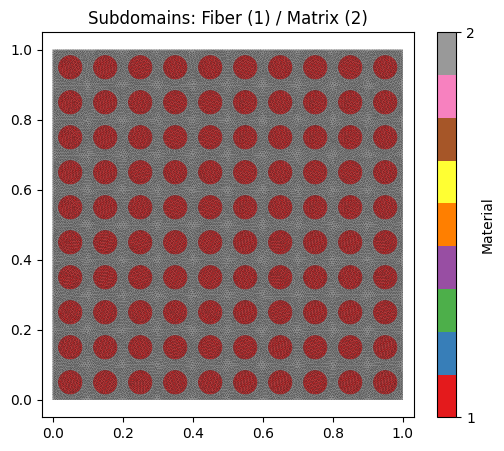

In [5]:
# Get cell markers as array
 
import matplotlib.pyplot as plt
cell_values = cell_markers.array()

plt.figure(figsize=(6, 5))
plt.tripcolor(points[:, 0], points[:, 1], triangles, 
              facecolors=cell_values, 
              cmap="Set1", 
              edgecolors='k', 
              linewidth=0.1)
plt.title("Subdomains: Fiber (1) / Matrix (2)")
plt.axis("equal")
plt.colorbar(ticks=[1, 2], label="Material")
plt.show()

In [6]:
from dolfin import File
import os
os.makedirs("results", exist_ok=True)
# Save as .pvd (FEniCS 2019 compatible)
File("results/u1.pvd") << u1 #[create folder results with u1 and u2 files :"<<"" means to write to file]
File("results/u2.pvd") << u2
File("results/subdomains.pvd") << cell_markers

 

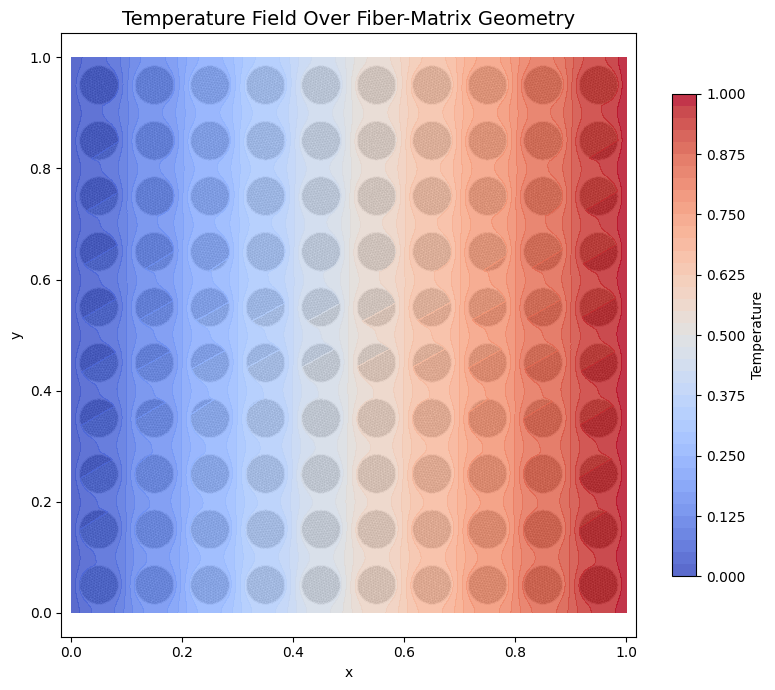

In [7]:
import matplotlib.pyplot as plt
from dolfin import plot

plt.figure(figsize=(8, 7))

#Plot geometry (fibers = white/gray, matrix = dark) — faint background
plot(cell_markers, cmap="gray", alpha=0.4, zorder=1)

# Overlay temperature field (semi-transparent so geometry shows through)
pp = plot(u1, cmap="coolwarm", alpha=0.85, zorder=2)

plt.colorbar(pp, label="Temperature", shrink=0.8)
plt.title("Temperature Field Over Fiber-Matrix Geometry", fontsize=14)
plt.xlabel("x"); plt.ylabel("y")
plt.axis("equal")
plt.tight_layout()
plt.show()